# Music Genre Classifier

## Project Topic
I have always been a person who likes music and I thought doing something involving music waveforms would be interesting. Originally my thought was to create a classifier to show you what decade the song takes insperation from based on confidence values. I will use that as a stretch goal for my project but the original use would be just to create a genre classifier and a decade classifier. In this project I tried a few different model trainings such as DecisionTrees with Ada Boost, Linear Regression, and SVC. As well as trying to find hyperparameters using gridSearchCV
Github link: https://github.com/deri9377/Devin_Riess_ML_Final



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt 

# Data Set

Since access to a large set of music files is difficult, I went to kaggle and looked around for music data sets and there were a lot to choose from. I did not use the wav file processing in this project since getting access to those is more difficult I used csv files that had features that I was looking for. https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre


### Lets Ingest the datafile

In [3]:
df = pd.read_csv('music_genre/music_genre.csv')
cols = df.columns
print(df.dtypes)
df.head()
df.shape

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object


(50005, 18)

### About the Data

This file has 18 features in total with 50,005 rows. Most of the features are float but some pre-processing needs to be done in order to use the data
- We remove the artist_name, instance_id, track_name, and obtained_date using a simple df drop since there are values that are not usefull to the model since they are unique identifiers
- We drop any rows that have na values, these values will cause our trainings to fail so you can either remove the rows or fill in with predictive data, for this project I decided to drop the rows.
- We convert music_genre, key, and mode to unique identifiers these were good predictive features and needed to be used in our model. We conver the strings into integers by using unique numerical identifiers.
- after pre processing we are left with 45,020 rows and 14 features

Were going to split the data into X, y and Test and Train

In [4]:
# Convert Feature labels to numerical values
df = df.dropna()
genres =df['music_genre'].unique()
key = df['key'].unique()
mode = df['mode'].unique()
df['music_genre'].replace(genres, [i for i in range(len(genres))], inplace=True)
df['key'].replace(key, [i for i in range(len(key))], inplace=True)
df['mode'].replace(mode, [i for i in range(len(mode))], inplace=True)
df = df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis=1)
# Extract X and y
df = df[~df.isin(['?', 'NaN']).any(axis=1)]
print(df.shape)

(45020, 14)


C:\Users\devin\AppData\Local\Temp\ipykernel_2828\2352341617.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['music_genre'].replace(genres, [i for i in range(len(genres))], inplace=True)
C:\Users\devin\AppData\Local\Temp\ipykernel_2828\2352341617.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True

## EGA

Here is an inital correlation map of the Data after pre-processing. As can be seen in the correlation heatmap there are not that many features that have a strong correlation with music_genre. The highest correlation appears to be popularity at around 0.31. This is not a good sign for accurate model prediction. There are a few other features that have stronger correlations here. They include acousticness and loudness. I also believe that popularity might be an interesting label to try. Since most of this data has weak correlation, there might be some issue with overfitting with stronger models.

<Axes: >

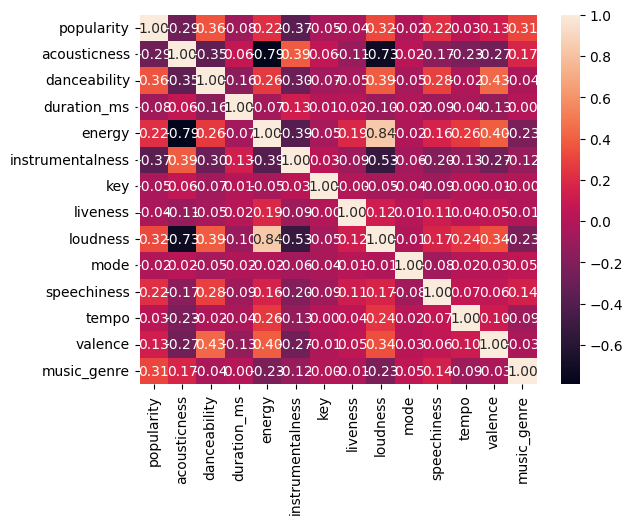

In [4]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")

In [6]:
# Splitting the data into X and y
y = df['music_genre']
X = df[[col for col in df.columns if col not in ['music_genre',]]]

print(X.shape, y.shape)

# Create Test and Train, going with a classic 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45020, 13) (45020,)
(36016, 13) (9004, 13) (36016,) (9004,)


# Setting up the Model (AdaBoost)

For this project an AdaBoostClassifier wil be used. When doing the number image classifier we used the AdaBoost method and I liked the approach so I decided to use that here as well. Starting off with a few simple example test with basic parameters. I use a DecisionTreeClassifier with max depth = 3 and number of estimators around 100. The result initially are pretty poor resulting in only around .5 - .55 accuracy.

In [9]:
# Ada Boost and Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=3)
clf = AdaBoostClassifier(estimator=tree, n_estimators=100, random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)


0.5146601510439804

In [8]:
tree = DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=tree, n_estimators=200, learning_rate=0.5, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.54


## Improving Results (Hyperparameter tuning)
It would appear the Ada boost is not very good at classifying the data. Lets try changing some variables to see if we can get a better classification.
lets use GridSearchCV to try and find some hyper parameters. These cells took a while to run since I had a lot of different parameters that I was testing. As can be seen from the results we were unable to get anything above 0.55 accuracy.

In [7]:
parameters = {'estimator__max_depth':[i for i in range(2,11,2)],
              'estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier())
grid = GridSearchCV(abc, parameters, verbose=3, scoring='f1_micro', n_jobs=-1).fit(X_train, y_train)
best_params = grid.best_estimator_
print(best_params)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    min_samples_leaf=10),
                   learning_rate=0.01, n_estimators=1000)


## Cross Validation

I attempted to use some simple cross validation here to find the best results using the best hyperparameters but still could not get the accuracy above 0.55

In [8]:
# get the value 
cross_val_score(best_params, X_test, y_test, cv=3)
# seems like 0.76 is the best the model will do at the current moment

array([0.54097268, 0.53648784, 0.54948351])

## Logistic Regression
I believed hat a simpler model would be better since it would tend to not overfit but it was also quite poor.

In [12]:
clf = LogisticRegression(max_iter=1000, random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.31


C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Linear Regression
The thought process here was similar but I got ever worse results

In [33]:
m = LinearRegression().fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.15


## SVC

In [30]:
clf = SVC(kernel='rbf', C=1.0, random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.15


## Trying a different Label

I took the approach to finding a label that had a lot of strong correlation in the data to see if we could get some better results

In [17]:
y = np.floor(df['loudness'])
X = df[[col for col in df.columns if col not in ['loudness',]]]

print(X.shape, y.shape)

# Create Test and Train, going with a classic 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45020, 13) (45020,)
(36016, 13) (9004, 13) (36016,) (9004,)


In [18]:
# Ada Boost and Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=3)
clf = AdaBoostClassifier(estimator=tree, n_estimators=100, random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.15459795646379387

## Again trying to improve the accuracy through search with GridSearchCV

In [7]:
parameters = {'estimator__max_depth':[i for i in range(2,11,2)],
              'estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier())
grid = GridSearchCV(abc, parameters, verbose=3, scoring='f1_micro', n_jobs=-1).fit(X_train, y_train)
best_params = grid.best_estimator_
print(best_params)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    min_samples_leaf=5),
                   learning_rate=0.1, n_estimators=1000)


In [6]:
best_params = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,min_samples_leaf=5),learning_rate=0.1, n_estimators=1000)
cross_val_score(best_params, X_test, y_test, cv=3)

C:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


array([0.22518321, 0.22559147, 0.2125958 ])

# Popularity

I thought that popularity might be a good problem to solve as well but it turned out to do the worst out of all of the test data

In [19]:
y = np.floor(df['popularity'])
X = df[[col for col in df.columns if col not in ['popularity',]]]

print(X.shape, y.shape)

# Create Test and Train, going with a classic 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45020, 13) (45020,)
(36016, 13) (9004, 13) (36016,) (9004,)


In [20]:
tree = DecisionTreeClassifier(max_depth=3)
clf = AdaBoostClassifier(estimator=tree, n_estimators=100, random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.04875610839626832

# Summary

Throughout this project my models continued to get worse and worse with each training. Most of the data has weak correlation and so I think my models might have been overfitting on the data. I think that most of the powerfull models did poorly here. But even some of the weaker ones like linear and logistic regression did bad. Overall I tried a few different labels and music_genre seemed to do the best but still only reached 0.55 accuracy which is poor. I was surprised that trying some of the other labels resulted in even worse results like loudness and popularity. If anything I would expect a similar accuracy around 0.55. In the future I belive that creating your own dataset is a better way to ensure that your data is appropriate 
